## Faster R-CNN Workshop

### Content:

- Test this
- Test that

In [38]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
from torchvision.transforms import functional as TF

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


Number of parameters: 41755286
Pretrained: True


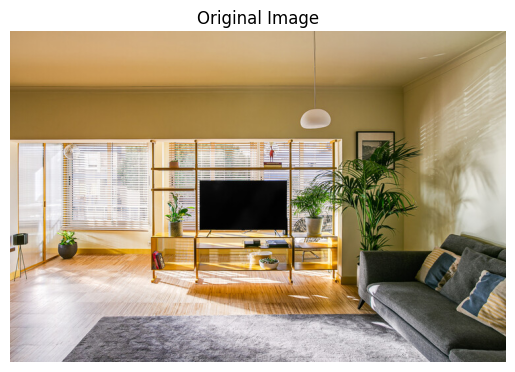

In [39]:
weights = FasterRCNN_ResNet50_FPN_Weights.COCO_V1
model = fasterrcnn_resnet50_fpn(weights=weights).to(device)
model.eval()

print("Number of parameters:", sum(p.numel() for p in model.parameters()))
print("Pretrained:", True)

# Load image
image = cv2.imread('data/indoor.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.axis('off')
plt.title("Original Image")
plt.show()

# Convert to tensor and add batch dimension
image_tensor = TF.to_tensor(image).unsqueeze(0).to(device)

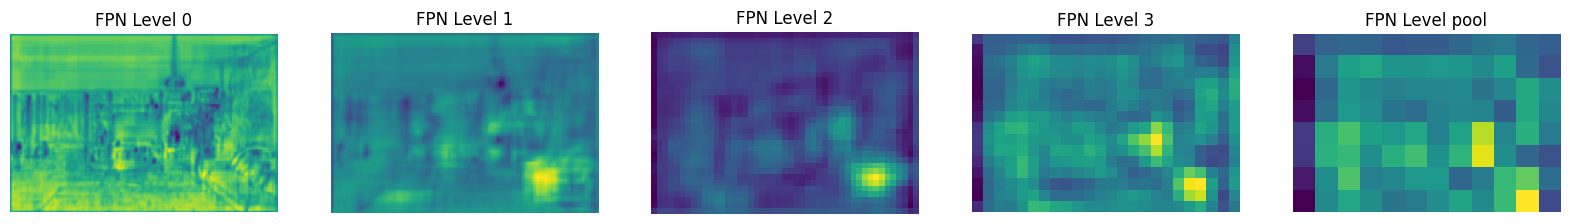

In [40]:
with torch.no_grad():
    features = model.backbone(image_tensor)

fpn_levels = ['0', '1', '2', '3', 'pool']  # corresponds to P3-P7
plt.figure(figsize=(20, 10))

for i, key in enumerate(fpn_levels):
    feat = features[key][0]  # [C, H, W]
    feat_mean = feat.mean(0).cpu()
    plt.subplot(1, len(fpn_levels), i+1)
    plt.imshow(feat_mean, cmap='viridis')
    plt.title(f"FPN Level {key}")
    plt.axis('off')

plt.show()

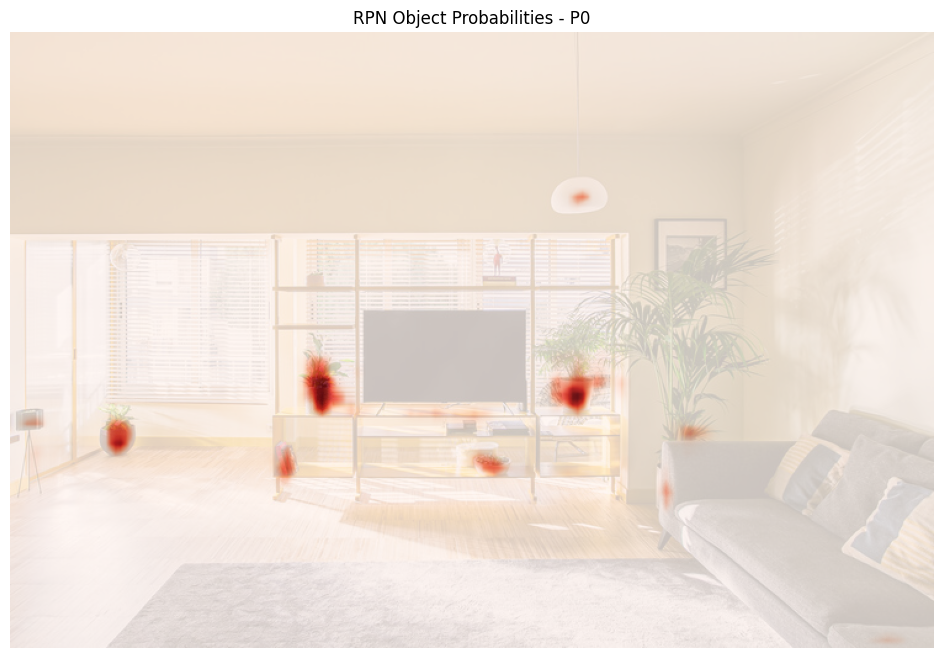

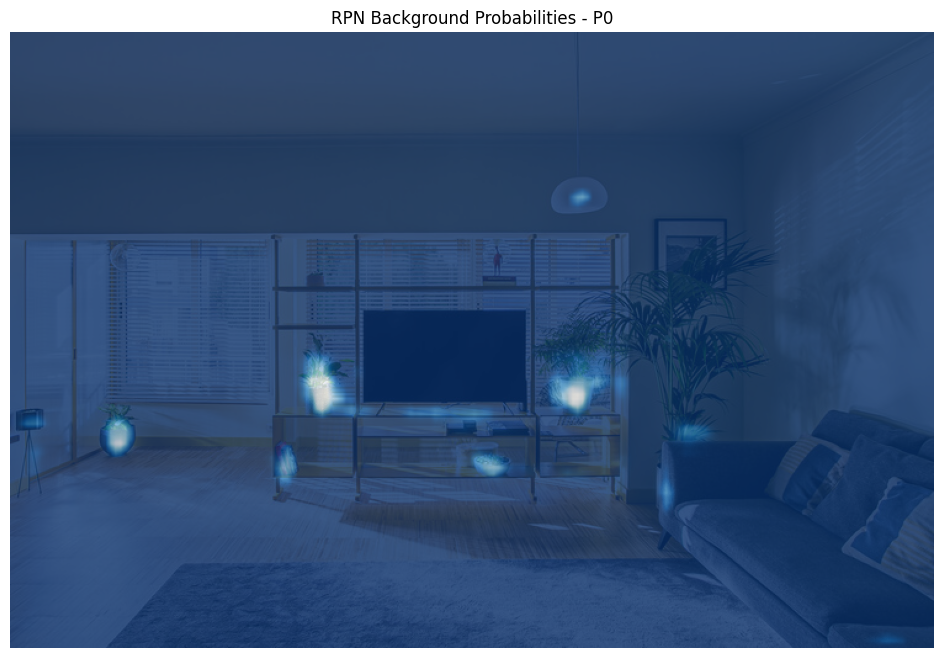

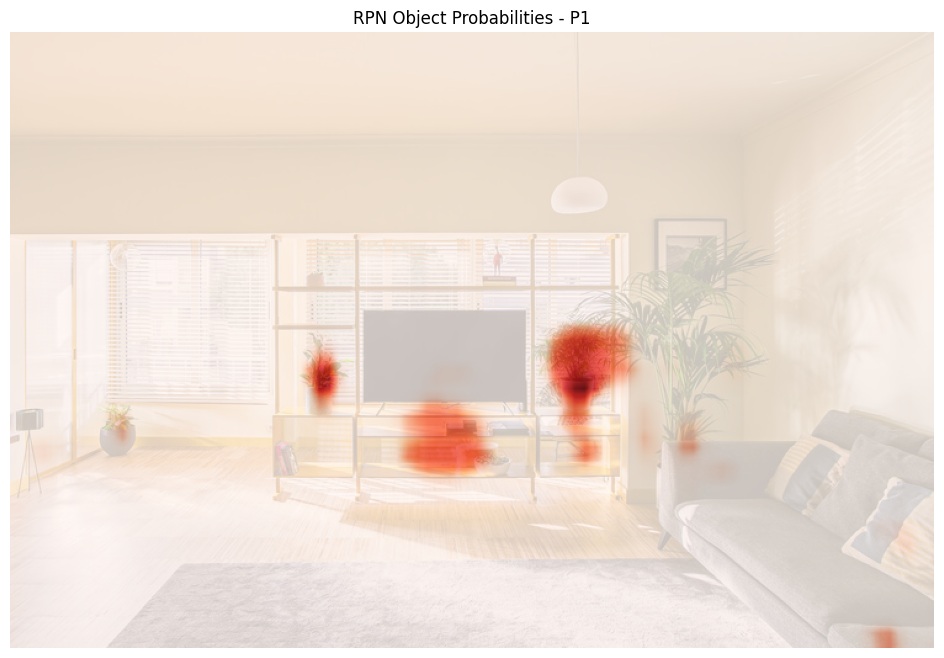

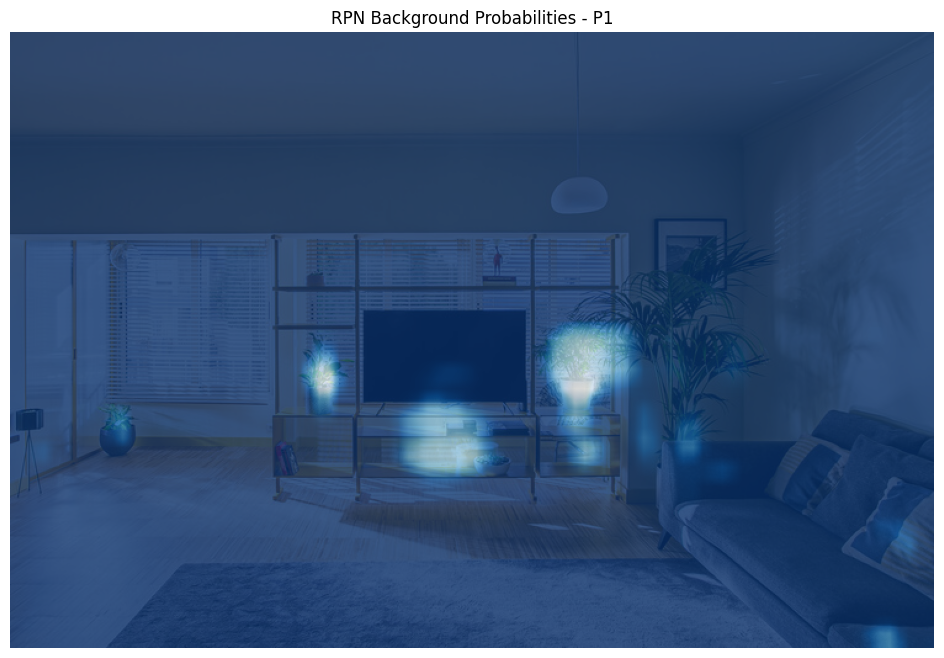

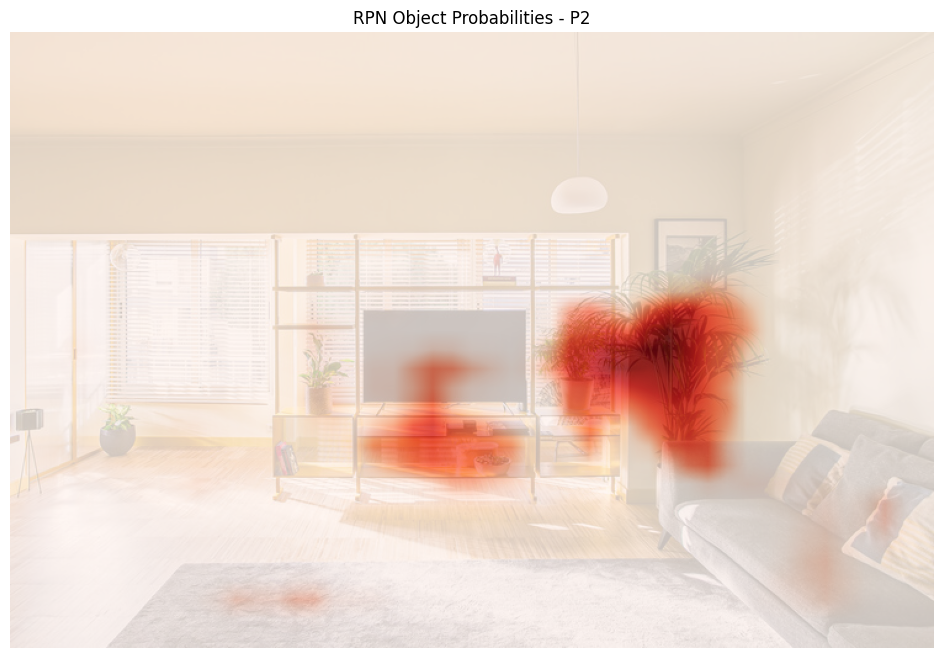

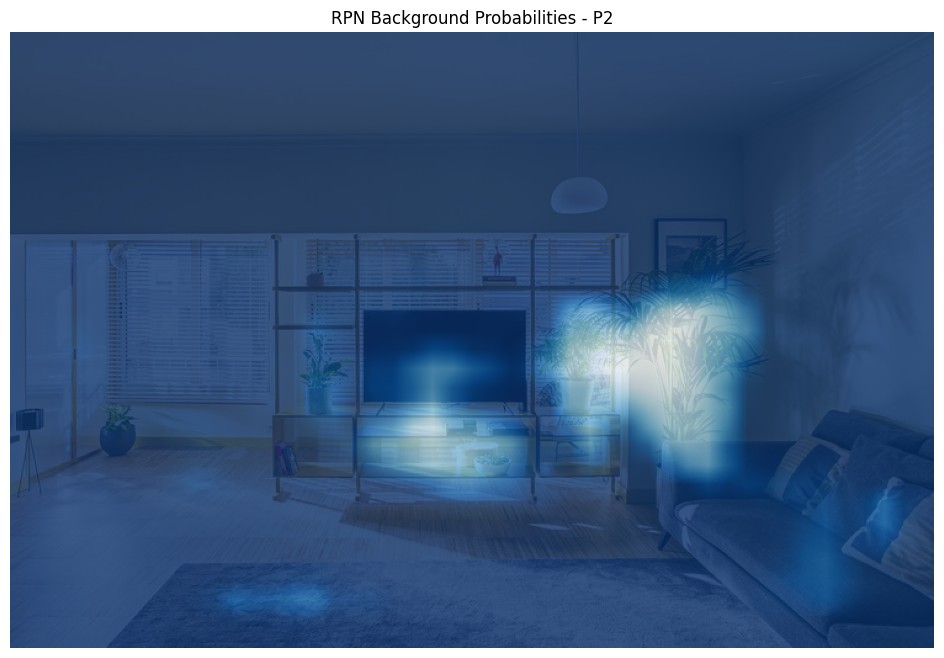

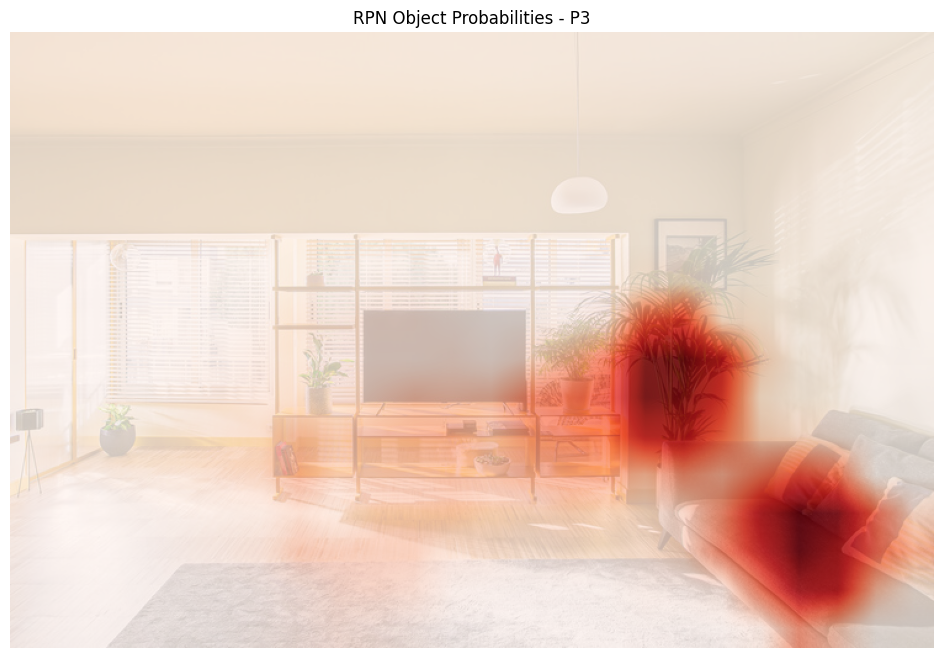

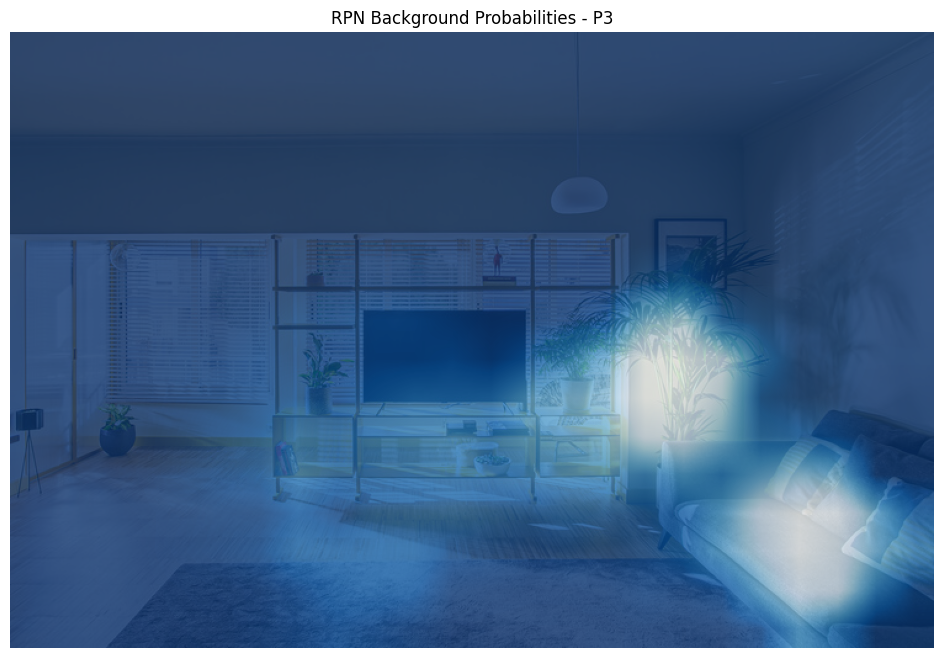

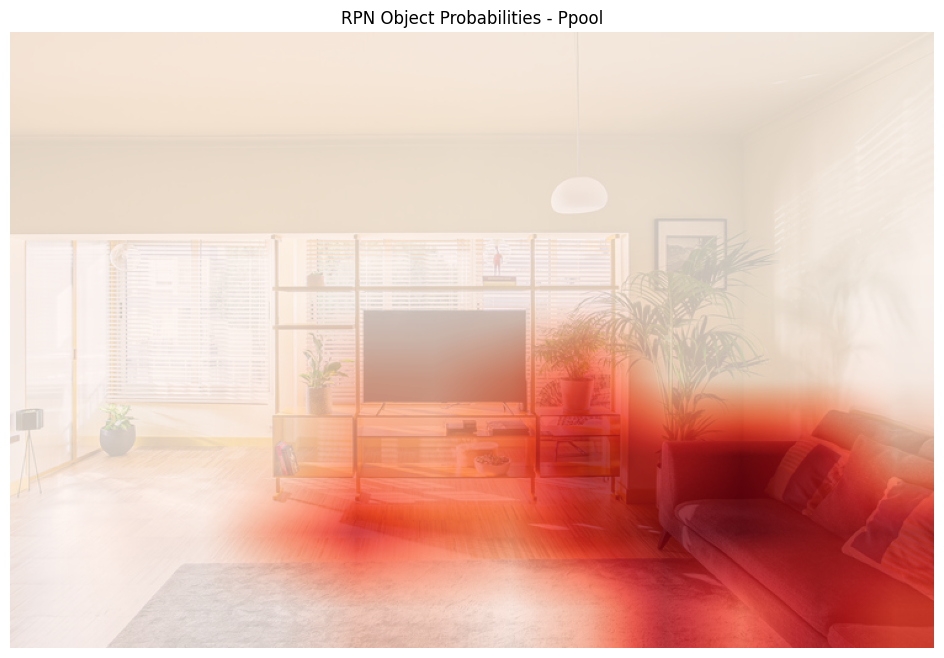

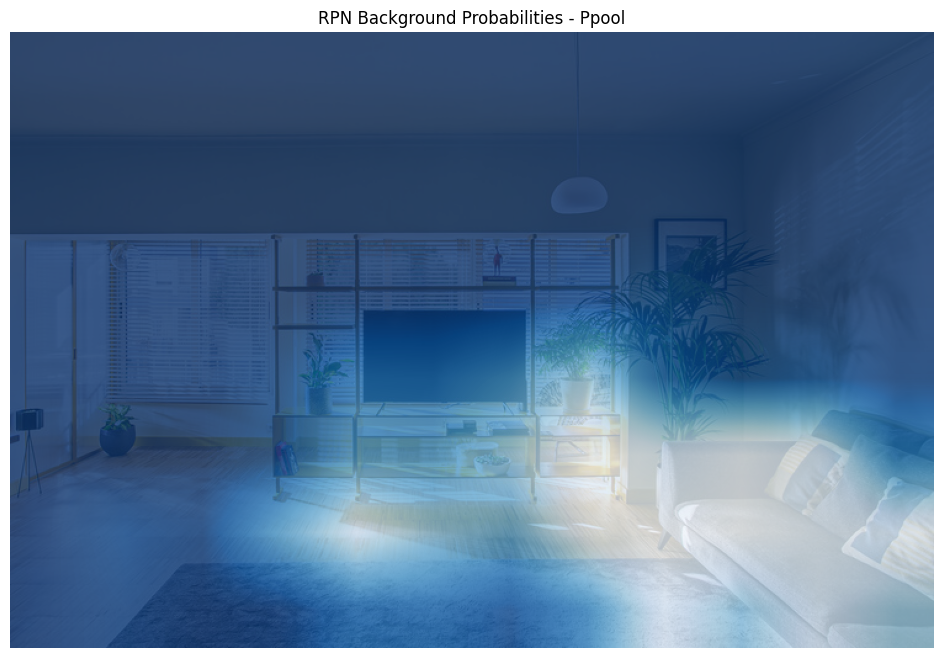

In [50]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

fpn_levels = ['0', '1', '2', '3', 'pool']

with torch.no_grad():
    for i, level in enumerate(fpn_levels):
        feat = features[level]  # [1, C, H, W]

        # RPN head expects a list of 4D tensors
        objectness_logits, _ = model.rpn.head([feat])
        objectness = objectness_logits[0]  # [1, num_anchors*2, H, W]

        # Convert logits to probabilities
        objectness_probs = torch.sigmoid(objectness)  # [1, num_anchors*2, H, W]

        # Take first anchor only OR mean across anchors
        num_anchors = objectness_probs.shape[1] // 2
        object_probs = objectness_probs[0, 0::2].mean(0)  # mean over object channels
        bg_probs = 1 - object_probs      # mean over background channels

        # Resize to original image size
        object_resized = F.interpolate(
            object_probs.unsqueeze(0).unsqueeze(0),
            size=image_tensor.shape[2:], mode='bilinear', align_corners=False
        )[0, 0]

        bg_resized = F.interpolate(
            bg_probs.unsqueeze(0).unsqueeze(0),
            size=image_tensor.shape[2:], mode='bilinear', align_corners=False
        )[0, 0]

        # Plot each level in a separate figure
        plt.figure(figsize=(12, 8))
        plt.imshow(image_rgb)
        plt.imshow(object_resized.cpu(), alpha=0.8, cmap='Reds')
        plt.title(f'RPN Object Probabilities - P{level}')
        plt.axis('off')
        plt.show()

        plt.figure(figsize=(12, 8))
        plt.imshow(image_rgb)
        plt.imshow(bg_resized.cpu(), alpha=0.8, cmap='Blues')
        plt.title(f'RPN Background Probabilities - P{level}')
        plt.axis('off')
        plt.show()

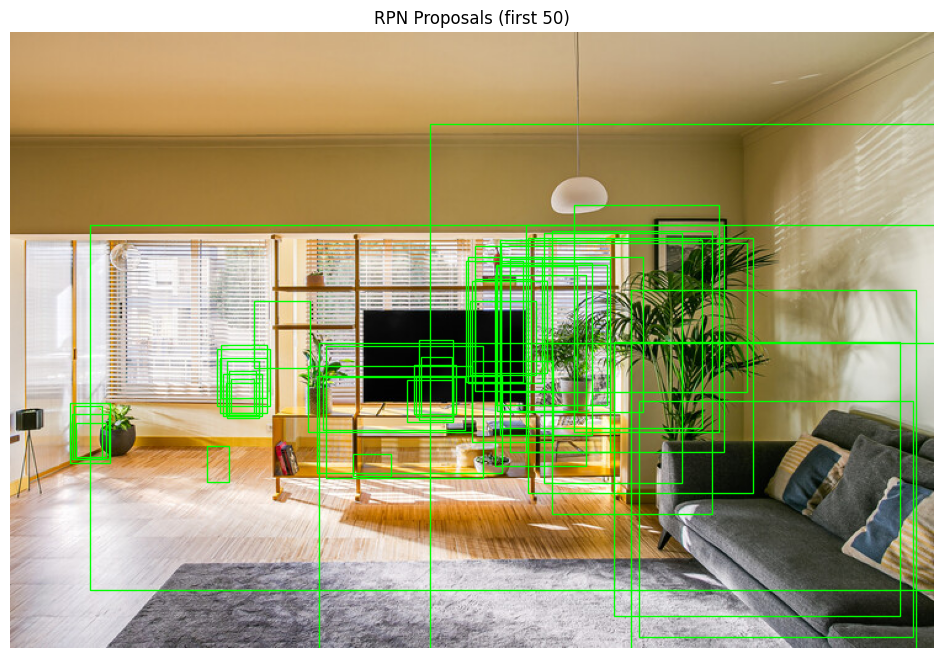

In [62]:
import matplotlib.patches as patches
from torchvision.models.detection.image_list import ImageList

# Settings
max_rois = 50

with torch.no_grad():
    # Prepare ImageList (RPN expects this)
    image_sizes = [(image_tensor.shape[2], image_tensor.shape[3])]
    images_list = ImageList(image_tensor, image_sizes)

    # Backbone features
    features = model.backbone(image_tensor)

    # Generate RPN proposals
    proposals, _ = model.rpn(images_list, features)
    proposals = proposals[0][:max_rois]  # take first N proposals

    # Overlay proposals on the original image
    fig, ax = plt.subplots(1,1, figsize=(12,8))
    ax.imshow(image_rgb)
    for box in proposals.cpu():
        x1, y1, x2, y2 = box
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=1, edgecolor='lime', facecolor='none'
        )
        ax.add_patch(rect)
    ax.set_title(f'RPN Proposals (first {max_rois})')
    ax.axis('off')
    plt.show()

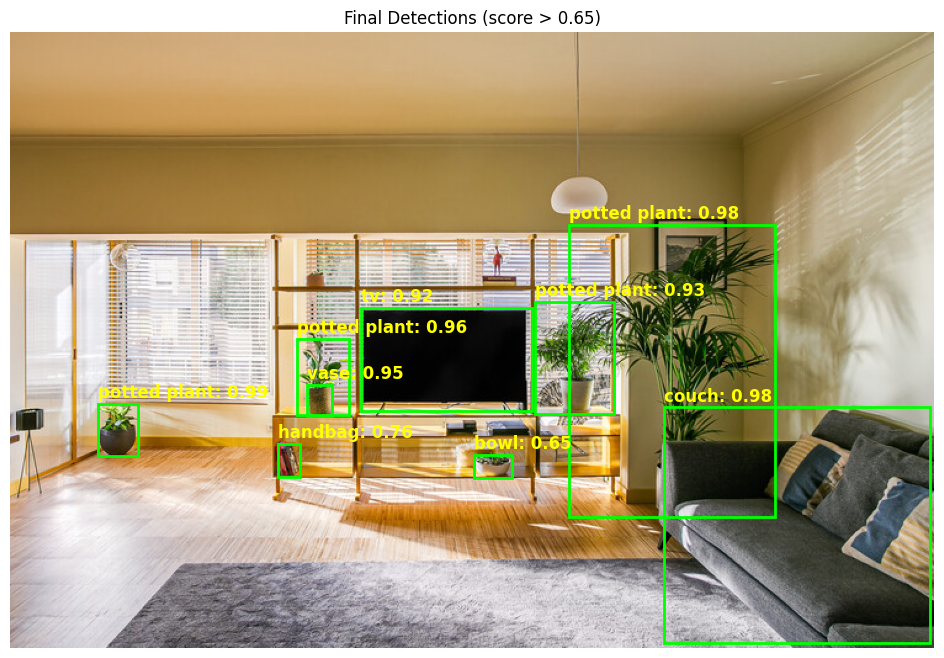

In [66]:
score_threshold = 0.65  # only show boxes with prob > threshold

with torch.no_grad():
    # Forward pass through the full model
    outputs = model(image_tensor)  # list of dicts per image
    output = outputs[0]

    boxes = output['boxes'].cpu()          # [N,4]
    scores = output['scores'].cpu()        # [N]
    labels = output['labels'].cpu()        # [N]

    # Map COCO class indices to names
    coco_classes = weights.meta["categories"]

    # Filter boxes by score
    keep = scores > score_threshold
    boxes = boxes[keep]
    scores = scores[keep]
    labels = labels[keep]

    # Plot final predictions
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(image_rgb)

    for box, score, label in zip(boxes, scores, labels):
        x1, y1, x2, y2 = box
        class_name = coco_classes[label.item()]
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=2, edgecolor='lime', facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(
            x1, y1 - 5,
            f"{class_name}: {score:.2f}",
            color='yellow', fontsize=12, weight='bold'
        )


    ax.set_title(f'Final Detections (score > {score_threshold})')
    ax.axis('off')
    plt.show()